**Deep Learning - Clustering**

**Ali Fatta Maulana - 1103223228**

In [5]:
# Install gdown if not already installed
!pip install -U -q gdown

In [8]:
# Replace 'your_folder_id' with the actual folder ID
folder_id = 'https://drive.google.com/file/d/1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q/view?usp=drive_link'

# Download all files from the specified Google Drive folder
# The `--folder` flag indicates that the ID belongs to a folder
# The `--id` flag is for the folder ID
# The `--output` flag (optional) can specify a directory to save files,
# but by default, it will download to the current directory.
print(f"Downloading files from folder ID: {folder_id}")
!gdown --folder --id {folder_id}

print("Download complete. You can list the files in the current directory to see the downloaded content.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Failed to retrieve folder contents
Download complete. You can list the files in the current directory to see the downloaded content.


In [10]:
import pandas as pd

df = pd.read_csv('clusteringmidterm.csv')
display(df.head())

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Import Library

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Load dan Cleaning data

In [13]:
df = pd.read_csv('clusteringmidterm.csv')

print("Data Shape Awal:", df.shape)

# Drop CUST_ID karena tidak berguna untuk pola clustering
if 'CUST_ID' in df.columns:
    df = df.drop('CUST_ID', axis=1)

# Handling Missing Values
# Mengisi NaN dengan Median (lebih aman terhadap outliers daripada Mean)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)

print("Jumlah Missing Values setelah cleaning:", df.isnull().sum().sum())

Data Shape Awal: (8950, 18)
Jumlah Missing Values setelah cleaning: 0


/tmp/ipython-input-2309562951.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)
/tmp/ipython-input-2309562951.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

Feature Engineering & Pre Processing

In [14]:
# Menangani Outliers & Skewness: Log Transformation
# Data keuangan biasanya sangat 'skewed' (banyak nilai kecil, sedikit nilai raksasa)
# Log transformation membuat distribusi data lebih normal agar Neural Network lebih mudah belajar.
# Kita tambah +1 agar tidak error saat log(0)
df_log = np.log1p(df)

# Scaling Data (Wajib untuk Deep Learning)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_log)

print("Data siap untuk training. Shape:", df_scaled.shape)

Data siap untuk training. Shape: (8950, 17)


Membuat Deep Learning Model (AutoEncoder)

In [15]:
input_dim = df_scaled.shape[1]

# Arsitektur Encoder (Kompresi)
input_layer = Input(shape=(input_dim,))
encoded = Dense(10, activation='relu')(input_layer) # Hidden layer 1
encoded = Dense(7, activation='relu')(encoded)      # Hidden layer 2

# Latent Space (Intisari Data)
# Kita kompres menjadi 4 dimensi fitur utama
latent_view = Dense(4, activation='relu', name='latent_space')(encoded)

# Arsitektur Decoder (Rekonstruksi)
decoded = Dense(7, activation='relu')(latent_view)
decoded = Dense(10, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Gabungkan Model
autoencoder = Model(input_layer, output_layer)
encoder_model = Model(input_layer, latent_view) # Model ini yang nanti dipakai untuk clustering

# Compile Model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            77 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 17)             │           187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591 (2.31 KB)

 Trainable params: 591 (2.31 KB)

 Non-trainable params: 0 (0.00 B)

Training Model Deep Learning


Mulai Training Autoencoder...
Training Selesai.


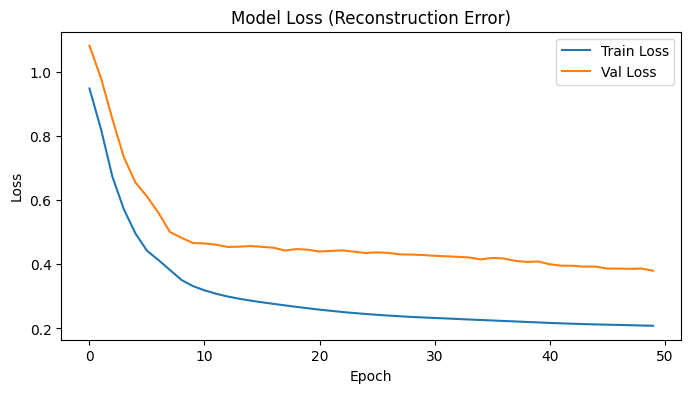

In [16]:
print("\nMulai Training Autoencoder...")
history = autoencoder.fit(df_scaled, df_scaled,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0) # Set verbose=1 jika ingin melihat progress bar
print("Training Selesai.")

# Visualisasi Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Reconstruction Error)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Clustering

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


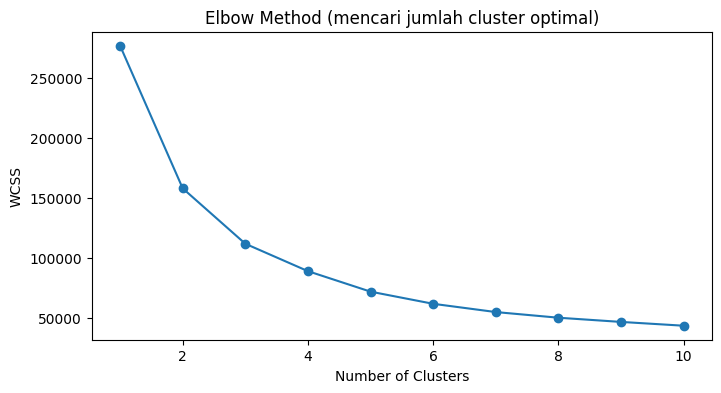


Silhouette Score pada Latent Features: 0.3523

=== Profiling Cluster (Rata-rata per Cluster) ===
             BALANCE    PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  \
CLUSTER                                                                      
0         154.310009  1166.397682    281.949019   4252.625466  1627.117326   
1        2290.694116    39.880934   2092.657687   4181.306326  1653.715974   
2        1733.683211  1853.844668    718.548987   5227.113200  2220.217676   
3        1840.038761   665.869383    846.060905   4032.573665  1257.049285   

         PRC_FULL_PAYMENT  
CLUSTER                    
0                0.518107  
1                0.023682  
2                0.120044  
3                0.014129  


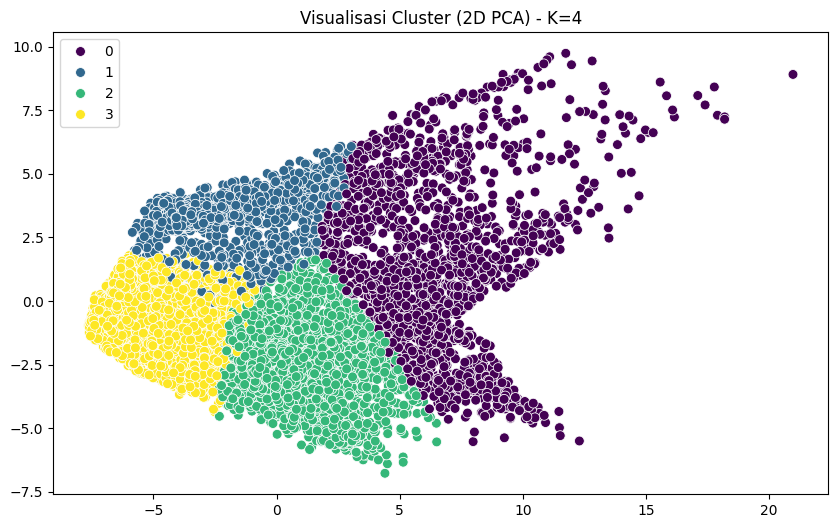

In [17]:
latent_features = encoder_model.predict(df_scaled)

# Mencari jumlah cluster optimal (Elbow Method)
wcss = []
range_n_clusters = range(1, 11)
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(latent_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,4))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method (mencari jumlah cluster optimal)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# --- TERAPKAN FINAL CLUSTERING ---
# Misal dari grafik Elbow kita pilih k=4 (Silakan ganti n_clusters sesuai grafik)
k_best = 4
kmeans_final = KMeans(n_clusters=k_best, init='k-means++', random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(latent_features)

# Tambahkan label cluster ke data asli
df['CLUSTER'] = clusters

# Evaluasi: Silhouette Score
# Score mendekati 1 = Cluster terpisah dengan sangat baik
sil_score = silhouette_score(latent_features, clusters)
print(f"\nSilhouette Score pada Latent Features: {sil_score:.4f}")

# ==========================================
# 6. EXPLAINING CLUSTERS (PROFILING)
# ==========================================
print("\n=== Profiling Cluster (Rata-rata per Cluster) ===")
# Kita group data asli berdasarkan cluster untuk melihat perilakunya
cluster_profile = df.groupby('CLUSTER').mean()
print(cluster_profile[['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']])

# Visualisasi Distribusi Cluster dengan PCA (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)
plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=clusters, palette='viridis', s=50)
plt.title(f'Visualisasi Cluster (2D PCA) - K={k_best}')
plt.show()